## Hyperparameters

`judgyprophet` gives full control over hyperparameters. These are mainly scale parameters which determine how sensitive `judgyprophet` is to actuals. The most useful of these are:

* `sigma_level` -- each level event is assigned a Normal prior with mean the business estimate ('c0'), and standard deviation is set to this arg. The lower this is, the closer the event will follow the business suggestions -- its default is 0.1.
* `sigma_trend` -- each trend event is assigned a Normal prior with mean the business estimate ('m0'), and standard deviation is set to this arg. The lower this is, the closer the event will follow the business suggestions -- its default is 0.1.
* `sigma_unspecified_changepoints` -- each unspecified changepoint is assigned a Laplace prior (equivalent to L1 penalty) with mean 0, and standard deviation set to this arg. The lower this is, the less likely the model will use this changepoint.

Other hyperparameters are:

* `sigma_base_bias` -- the initial bias is assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.
* `sigma_base_trend` -- the initial trend is assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.
* `sigma_seasonal` -- the seasonality parameters are assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.

### Example of Hyperparameter impact
The default hyperparameter values for `judgyprophet` tend to deliver reasonable estimations. However, there might be situations in which you would like to adjust those to pay more or less attention to prior knowledge. Values between 1 and 0.01 seem to deliver quite stable results.

We will now adjusting the prior for the trend event to understand the hyperparameter impact. Let's load again the time series which contains a damped trend event and additive seasonality which we saw in the Seasonality tutorial. This time, we added some correlated noise after the trend event happened (between April and August 2018):

<AxesSubplot:>

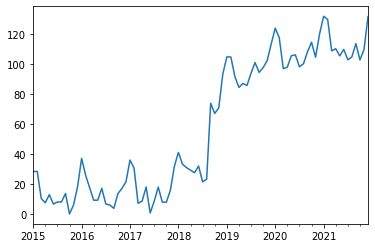

In [1]:
from judgyprophet.tutorials.resources import get_additive_seasonal_damped_trend_event_correlated_noise

example_data = get_additive_seasonal_damped_trend_event_correlated_noise()
example_data.plot.line()

The trend event parameters in this case are the exact solution to trend shown in the above time series:

In [2]:
trend_events = [
    {'name': "New saturating market entry", 'index': '2018-01-01', 'm0': 9, 'gamma': .9}
]

#### Forecasting with the default hyperparameters
We are now creating a forecast in July 2017. Using the default value for `sigma_trend` creates the following forecast:

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2018-01-01, training data start index: 2015-01-01 00:00:00, training data end index: 2018-08-01 00:00:00. Initial gradient: 9. Damping: 0.9.


Initial log joint probability = -1125.09
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      17      -24.2744   0.000161304    0.00638672           1           1       31   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

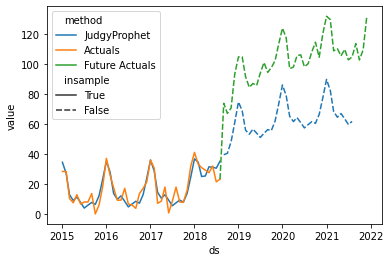

In [3]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns


# Cutoff the data to June 2017
cutoff = "2018-08-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=0.1,
    level_events=[],
    unspecified_changepoints=0,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

Nevertheless, the default hyperparameter tend to underestimate the impact of the trend event: Since the model is learning from the previously observed data points (which contain the correlated noise), the model assumes that the prior trend event estimates were inaccurate and it corrects the estimated trend downwards.

#### Testing a very low `sigma_trend` value 
If we are certain that our prior knowledge is correct and we assume a high volatility in our time series, we can reduce the prior value for `sigma_trend`. That will encourge the model to strictly follow initial trend event estimations given to it. In this case, adjusting the hyperparameter value can improve our forecast accuracy:

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2018-01-01, training data start index: 2015-01-01 00:00:00, training data end index: 2018-08-01 00:00:00. Initial gradient: 9. Damping: 0.9.


Initial log joint probability = -1191.51
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -42.6551     0.0255416       21.9616           1           1       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -40.5184     0.0027457       2.62096           1           1       51   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -40.4754   0.000243228      0.568846           1           1       74   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       -40.474   0.000184754      0.147366           1           1       99   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       -40.474   6.17252e-05     0.0258339           1           1      121   
Optimization terminated normally: 
  Convergence detected: relat

<AxesSubplot:xlabel='ds', ylabel='value'>

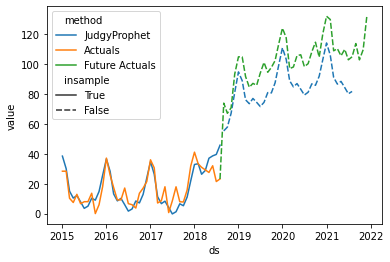

In [4]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns


# Cutoff the data to June 2017
cutoff = "2018-08-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=0.01,
    level_events=[],
    unspecified_changepoints=0,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

#### Testing a very high `sigma_trend` value 
If you are not certain if your estimations are correct prior to the event, it is sensible to assign a higher value to the `sigma_trend` parameter. This is beneficial in situations where our prior estimations are poorly. Let's look at the forecast created in November 2018:

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2018-01-01, training data start index: 2015-01-01 00:00:00, training data end index: 2018-11-01 00:00:00. Initial gradient: 1. Damping: 0.9.


Initial log joint probability = -962.005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -16.6821   0.000169582       0.22355           1           1       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       -16.682   0.000103557     0.0974231           1           1       50   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       -16.682   5.07955e-06     0.0182171      0.1133           1       78   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

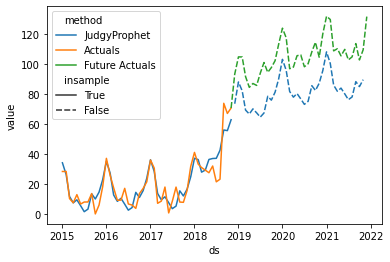

In [5]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns


# Cutoff the data to June 2017
cutoff = "2018-11-01"
data_cutoff = example_data.loc[:cutoff]

poor_trend_events = [
    {'name': "New saturating market entry", 'index': '2018-01-01', 'm0': 1, 'gamma': .9}
]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=10,
    level_events=[],
    unspecified_changepoints=0,
    sigma_unspecified_changepoints=.2,
    trend_events=poor_trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

The model with a large prior for `simga_trend` learned that the prior trend event estimates underestimated the trend change, and adjusted its forecast accordingly, whereas the default value would produce a larger forecasting error:

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2018-01-01, training data start index: 2015-01-01 00:00:00, training data end index: 2018-11-01 00:00:00. Initial gradient: 1. Damping: 0.9.


Initial log joint probability = -979.779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -21.5681   0.000488491      0.799235           1           1       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38      -21.5671   6.15078e-05    0.00396993       1.018      0.1018       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

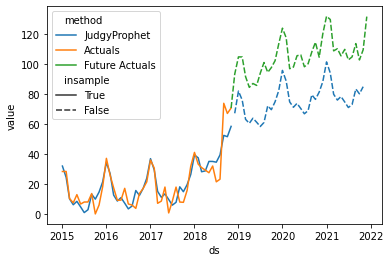

In [6]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns


# Cutoff the data to June 2017
cutoff = "2018-11-01"
data_cutoff = example_data.loc[:cutoff]

poor_trend_events = [
    {'name': "New saturating market entry", 'index': '2018-01-01', 'm0': 1, 'gamma': .9}
]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    sigma_trend=0.1,
    level_events=[],
    unspecified_changepoints=0,
    sigma_unspecified_changepoints=.2,
    trend_events=poor_trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(36))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])